# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 18, 17, 42, 45, 79246)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [ ]:
# with open('../../data/hopsworks-api-key.txt', 'r') as file:
#    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1169565
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [4]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_lagged_xgboost_model",
    version = 1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()


Connected. Call `.close()` to terminate connection gracefully.


In [5]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()


retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")


# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='1.0106045E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [22]:
weather_fg = fs.get_feature_group(
    name='weather',
    version= 1,
    )
lagged_aq_fg = fs.get_feature_group(
    name='air_quality_lagged',
    version= 1,
    )
batch_data = weather_fg.filter(weather_fg.date >= today).read()
df = lagged_aq_fg.read()

max_date = df['date'].max()

last_air_quality_lagged = df[df['date'] == max_date]

lagged_columns = ['lagged_1', 'lagged_2', 'lagged_3']

last_air_quality_lagged[lagged_columns] = last_air_quality_lagged[lagged_columns].apply(lambda row: row.fillna(last_air_quality_lagged['pm25']))



Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.69s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.01s) 
2024-11-18 17:49:39,890 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
print(last_air_quality_lagged)

                          date  pm25  lagged_1  lagged_2  lagged_3 country  \
1786 2024-11-18 00:00:00+00:00  24.0      24.0      24.0      24.0  Poland   

          city          street                                 url  
1786  Warszawa  Lokuciewskiego  https://api.waqi.info/feed/A65074/  


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [29]:
model_feature_names = retrieved_xgboost_model.get_booster().feature_names
print("Model feature names:", model_feature_names)


Model feature names: ['lagged_1', 'lagged_2', 'lagged_3', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']


In [30]:
# Ensure batch_data is sorted by date in chronological order
batch_data = batch_data.sort_values('date').reset_index(drop=True)

# Get initial lagged PM2.5 values from your latest known data
# Assuming 'last_air_quality_lagged' contains the latest lagged values
lagged_pm25_values = last_air_quality_lagged[['lagged_1', 'lagged_2', 'lagged_3']].iloc[0].tolist()

# List to store predictions
predictions = []

# Define the correct order of columns as per the model
model_feature_order = [ 'lagged_1', 'lagged_2', 'lagged_3', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 
                       'wind_direction_10m_dominant']

# Iterate over each row in the batch_data
for idx, row in batch_data.iterrows():
    # Extract weather features for the current day
    input_features = row[['temperature_2m_mean', 'precipitation_sum', 
                          'wind_speed_10m_max', 'wind_direction_10m_dominant']].copy()
    
    # Add lagged PM2.5 features
    input_features['lagged_1'] = lagged_pm25_values[0]
    input_features['lagged_2'] = lagged_pm25_values[1]
    input_features['lagged_3'] = lagged_pm25_values[2]
    
    # Convert the input features to a DataFrame for prediction
    input_df = pd.DataFrame([input_features])
    
    # Reorder the columns in input_df to match the model's feature order
    input_df = input_df[model_feature_order]
    
    # Make the prediction using your model
    prediction = retrieved_xgboost_model.predict(input_df)[0]
    
    # Store the prediction
    predictions.append(prediction)
    
    # Update lagged PM2.5 values for the next iteration
    lagged_pm25_values = [prediction] + lagged_pm25_values[:2]  # Keep the latest three values

# Add the predictions to your batch_data DataFrame
batch_data['predicted_pm25'] = predictions

# Print or process the batch_data as needed
print(batch_data)


                       date  temperature_2m_mean  precipitation_sum  \
0 2024-11-19 00:00:00+00:00                 2.80                0.1   
1 2024-11-20 00:00:00+00:00                 3.35                0.0   
2 2024-11-21 00:00:00+00:00                 1.70                0.0   
3 2024-11-22 00:00:00+00:00                 1.80                0.0   
4 2024-11-23 00:00:00+00:00                 2.05                0.1   
5 2024-11-24 00:00:00+00:00                 3.15                0.0   
6 2024-11-25 00:00:00+00:00                 6.85                0.0   
7 2024-11-26 00:00:00+00:00                 7.75                0.0   
8 2024-11-27 00:00:00+00:00                 5.30                0.0   

   wind_speed_10m_max  wind_direction_10m_dominant      city  predicted_pm25  
0           15.315873                   150.422256  Warszawa       26.749004  
1           17.068707                   297.645874  Warszawa       19.618015  
2           17.298738                   257.988556  

In [31]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), object(1)
memory usage: 452.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [32]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-19 00:00:00+00:00,2.80,0.1,15.315873,150.422256,Warszawa,26.749004,Lokuciewskiego,Poland,1
1,2024-11-20 00:00:00+00:00,3.35,0.0,17.068707,297.645874,Warszawa,19.618015,Lokuciewskiego,Poland,2
2,2024-11-21 00:00:00+00:00,1.70,0.0,17.298738,257.988556,Warszawa,19.920866,Lokuciewskiego,Poland,3
3,2024-11-22 00:00:00+00:00,1.80,0.0,6.369050,227.290634,Warszawa,28.335403,Lokuciewskiego,Poland,4
4,2024-11-23 00:00:00+00:00,2.05,0.1,14.044615,271.468781,Warszawa,28.840069,Lokuciewskiego,Poland,5
5,2024-11-24 00:00:00+00:00,3.15,0.0,18.345877,164.054535,Warszawa,25.153154,Lokuciewskiego,Poland,6
6,2024-11-25 00:00:00+00:00,6.85,0.0,9.605998,167.005386,Warszawa,22.464514,Lokuciewskiego,Poland,7
7,2024-11-26 00:00:00+00:00,7.75,0.0,19.930479,253.201538,Warszawa,21.945845,Lokuciewskiego,Poland,8
8,2024-11-27 00:00:00+00:00,5.30,0.0,16.923828,299.291260,Warszawa,19.550756,Lokuciewskiego,Poland,9


In [33]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float32            
 7   street                       9 non-null      object             
 8   country                      9 non-null      object             
 9   days_before_forecast_day     9 non-null      int64              
dtypes: datetime64[us, UTC](1), float32(5), int64(1), objec

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

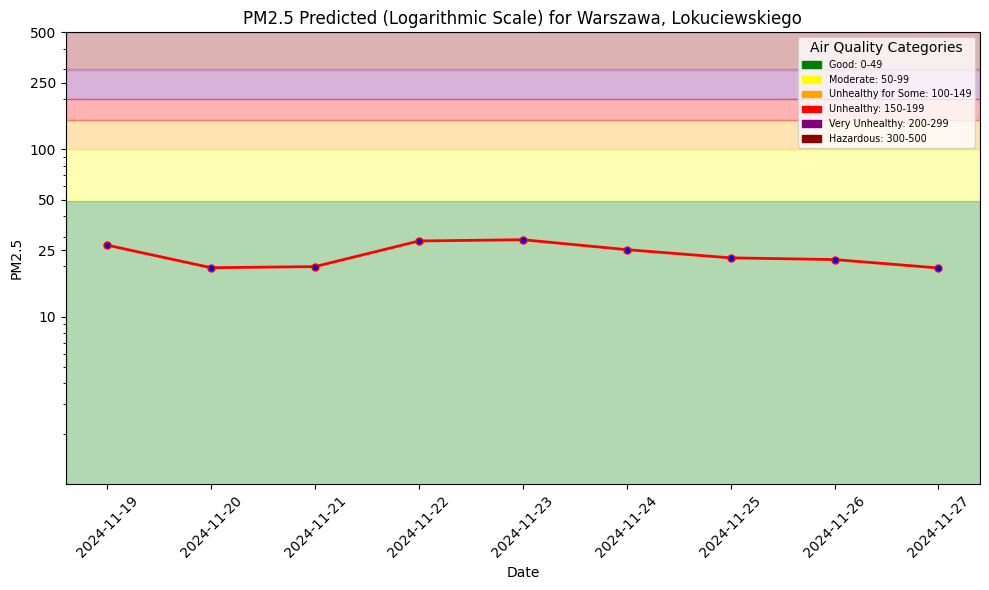

In [35]:
file_path = "../../docs/air-quality/assets/img/pm25_lagged_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [36]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_lagged_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [ ]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True}, overwrite=True)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1169565/fs/1160267/fg/1354087


Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_lagged_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1169565/jobs/named/aq_lagged_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x14d94ca00>, None)

In [43]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.70s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-19 00:00:00+00:00,2.8,0.1,15.315873,150.422256,Warszawa,26.749004,Lokuciewskiego,Poland,1


In [44]:
air_quality_fg = fs.get_feature_group(
    name='air_quality_lagged',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.96s) 


,date,pm25,lagged_1,lagged_2,lagged_3,country,city,street,url
0,2024-03-12 00:00:00+00:00,1.170000,3.200000,2.290000,0.890000,Poland,Warszawa,Lokuciewskiego,https://api.waqi.info/feed/A65074/
1,2022-05-05 00:00:00+00:00,3.190000,2.500000,3.230000,6.220000,Poland,Warszawa,Lokuciewskiego,https://api.waqi.info/feed/A65074/
2,2024-08-01 00:00:00+00:00,0.100000,0.100000,0.100000,0.200000,Poland,Warszawa,Lokuciewskiego,https://api.waqi.info/feed/A65074/
3,2024-06-20 00:00:00+00:00,0.100000,0.100000,0.000000,0.100000,Poland,Warszawa,Lokuciewskiego,https://api.waqi.info/feed/A65074/
4,2024-09-30 00:00:00+00:00,0.100000,0.100000,0.100000,0.100000,Poland,Warszawa,Lokuciewskiego,https://api.waqi.info/feed/A65074/
...,...,...,...,...,...,...,...,...,...
1782,2022-10-17 00:00:00+00:00,17.420000,12.800000,21.270000,18.469999,Poland,Warszawa,Lokuciewskiego,https://api.waqi.info/feed/A65074/
1783,2021-04-13 00:00:00+00:00,5.670000,4.900000,3.930000,13.550000,Poland,Warszawa,Lokuciewskiego,https://api.waqi.info/feed/A65074/
1784,2020-11-03 00:00:00+00:00,34.360001,40.099998,33.349998,35.900002,Poland,Warszawa,Lokuciewskiego,https://api.waqi.info/feed/A65074/
1785,2022-08-14 00:00:00+00:00,10.810000,7.070000,4.430000,1.930000,Poland,Warszawa,Lokuciewskiego,https://api.waqi.info/feed/A65074/


In [48]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])
# print(outcome_df)
# print(preds_df)
# # If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
# if len(hindcast_df) == 0:
#     hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

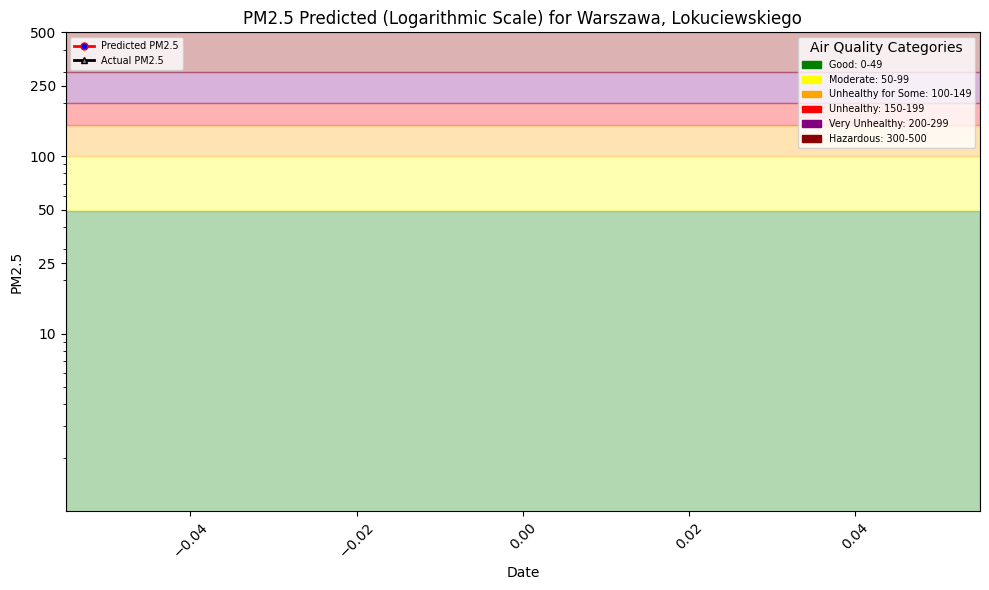

In [49]:
file_path = "../../docs/air-quality/assets/img/pm25_lagged_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---